In [1]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# label adapter FCN

## create our datasets

In [2]:
import torchvision.transforms as T
import torchvision.transforms.functional as F
import random
#import torchvision.transforms as T
#import torchvision.transforms.functional as F
import albumentations as albu
import random
import scipy
import torch
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import re

def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        albu.Rotate((-11,11),p=0.5),
        albu.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Perspective(p=0.4),
        #albu.GaussNoise(p=0.2),
        #albu.OneOf([albu.CLAHE(p=1),albu.RandomBrightness(p=1),albu.RandomGamma(p=1),],p=0.9,),
        #albu.OneOf([albu.Sharpen(p=1),albu.Blur(blur_limit=3, p=1),],p=0.9,),albu.OneOf([albu.RandomContrast(p=1),albu.HueSaturationValue(p=1),],p=0.9,),
    ]

    return albu.Compose(train_transform)


def transformation_augs():
    train_transform = [
        #albu.HorizontalFlip(p=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(128, 128)
    ]
    return albu.Compose(test_transform)

class MyDataSet(torch.utils.data.Dataset):

  #CLASSES =  ["background","facial_skin","left_brow","right_brow","left_eye","right_eye", "nose","upper_lip","inner_mouth","lower_lip","hair"]

  def __init__(self, images_dir, masks_dir, coords_dir, preprocessing=None, classes=None,augmentation=None, training=True):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    #self._x, self._y = x,y
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.image_ids = os.listdir(images_dir)

    train_slice = int(len(self.image_ids)*0.2)

    if training == True:
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][train_slice::]
      self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.image_ids][train_slice::]
    else:
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][:train_slice]
      self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.image_ids][:train_slice]

  def __len__(self):
    # a DataSet must know it size
    return len(self.images_fps)

  def __getitem__(self, i):

    image = cv2.imread(self.images_fps[i], 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)

    #print(self.images_fps[i])

    sample = self.augmentation(image=image, mask=mask)
    image, mask = sample['image'], sample['mask']

    image = torch.tensor(image)

    #onehot
    one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), 12).float()

    return (image.permute(2,0,1).float(), one_hot_Y.permute(2,0,1).float())


train_x_path = "/home/nathan/Documents/final_project/datasets/label_adapter_wood_train/images"
train_y_path = "/home/nathan/Documents/final_project/datasets/label_adapter_wood_train/masks"

val_x_path = train_x_path
val_y_path = train_y_path

train_ds2 = MyDataSet(train_x_path, train_y_path, None, augmentation=get_training_augmentation())
val_ds2 = MyDataSet(val_x_path, val_y_path, None, training=False, augmentation=get_validation_augmentation())


### Data Loader

In [3]:
from torch.utils.data import DataLoader

# Get train and val data loaders
train_loader2 = DataLoader(train_ds2, batch_size=24, shuffle=True, num_workers=7)
valid_loader2 = DataLoader(val_ds2, batch_size=24, shuffle=False, num_workers=7)


## Sanity Check

2023-02-17 19:37:59.195968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 19:37:59.516453: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-17 19:38:00.739670: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nathan/miniconda3/lib/python3.9/site-packages/cv2/../../lib64::/home/nathan/miniconda3/lib/:/home/nathan/miniconda3/lib/:/home/nathan/miniconda3/lib/
2023-02-17 19:38:00.739919: W tensorflow/stream_executor

torch.Size([3, 128, 128])
torch.Size([12, 128, 128])


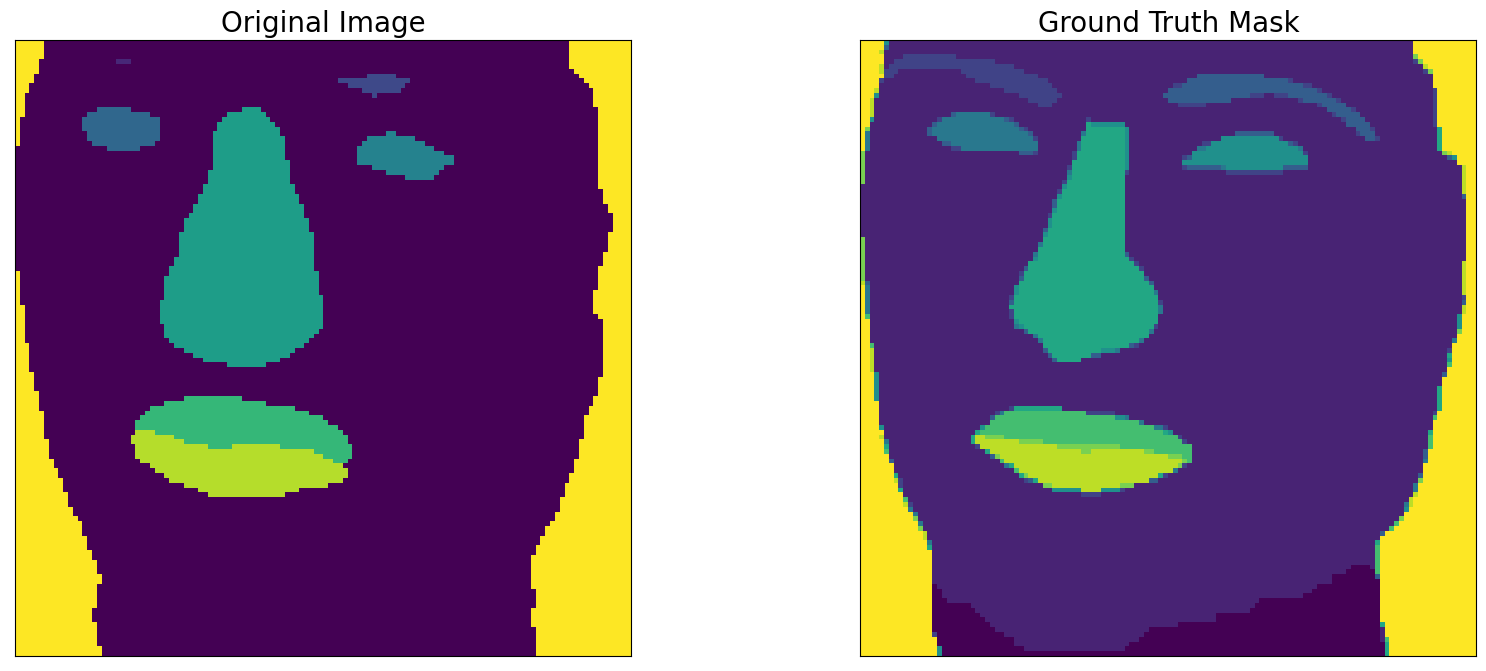

torch.Size([3, 128, 128])
torch.Size([12, 128, 128])


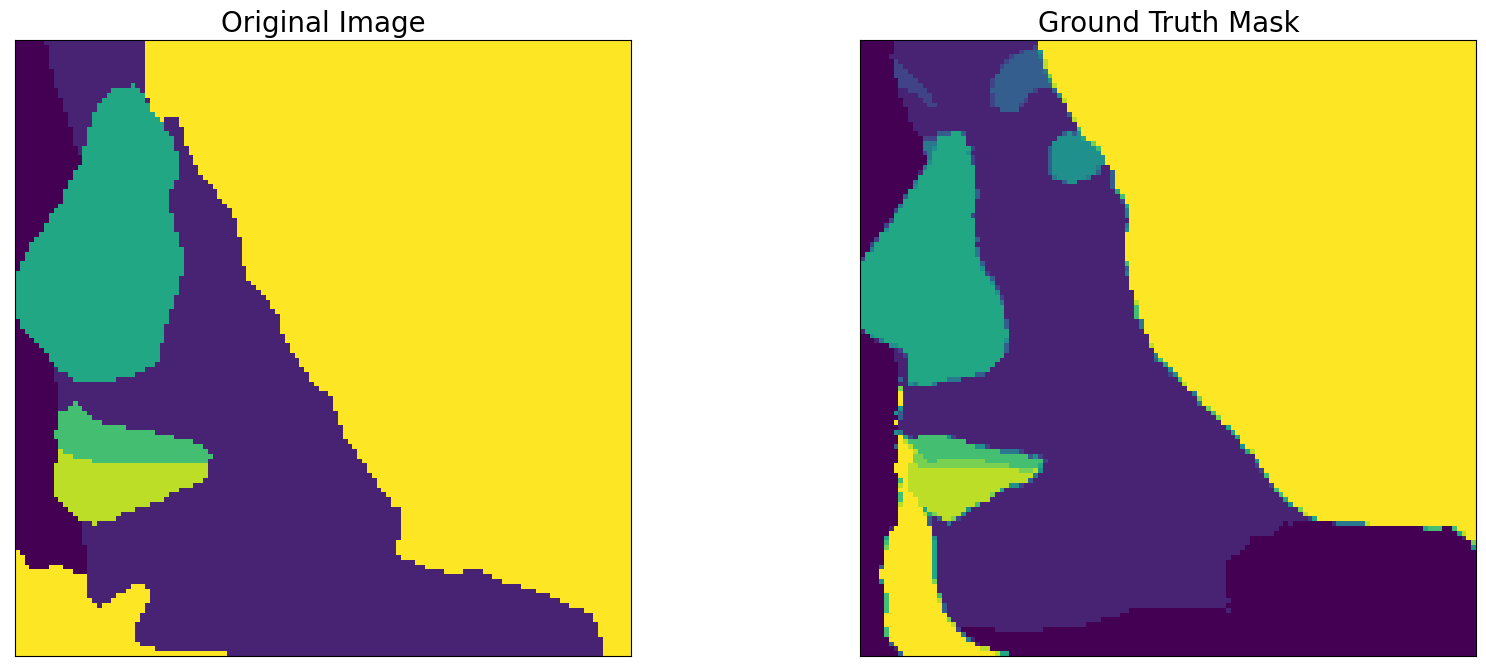

torch.Size([3, 128, 128])
torch.Size([12, 128, 128])


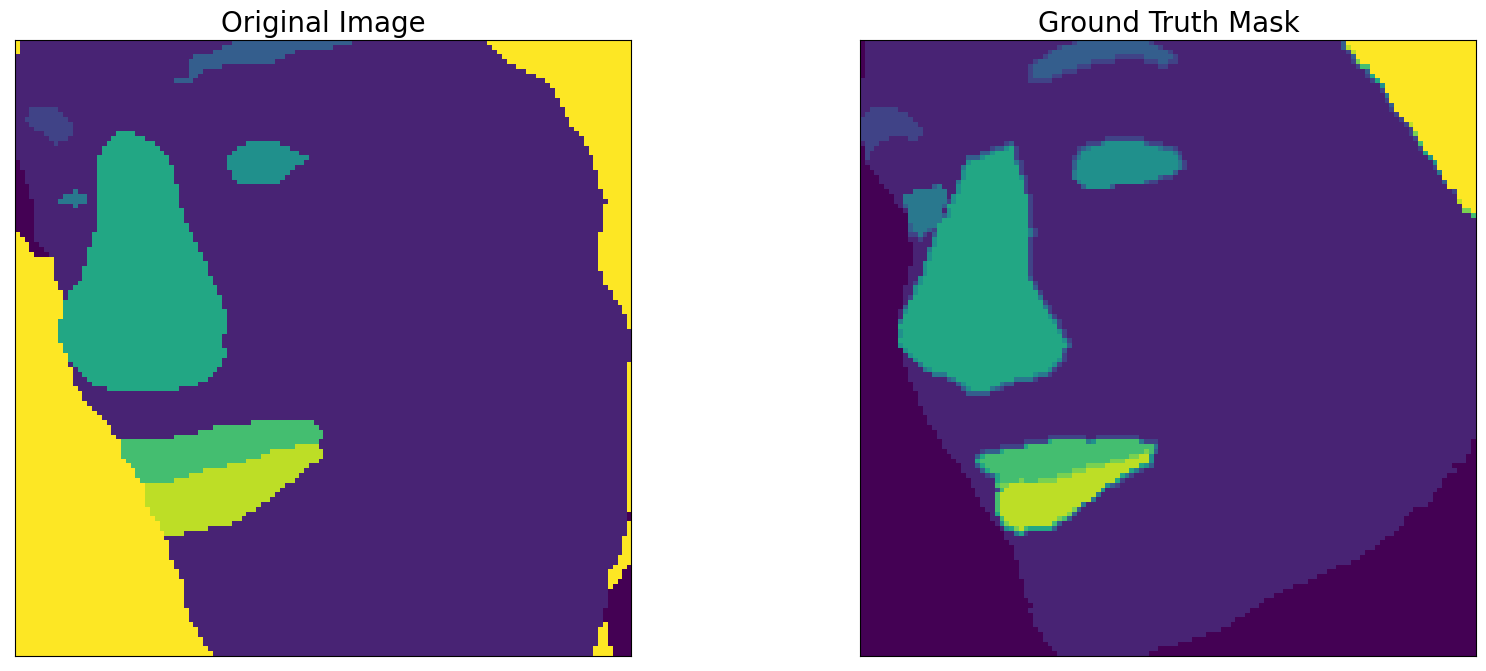

In [4]:
from PIL import ImageFilter
from scipy import ndimage
from collections import Counter
import label_test_script


for x in range(2):

    image_vis, gt_mask = train_ds2[x]
    print(image_vis.shape)
    print(gt_mask.shape)

    reverse = label_test_script.reverse_one_hot(gt_mask)

    skin_kernel = np.ones((4,4))

    tmp = scipy.ndimage.convolve(np.array(reverse), skin_kernel, mode='constant')
    filter = np.array(np.logical_and(np.array(tmp) >= 1, reverse)).astype(np.float32)

    label_test_script.visualize(
        original_image = image_vis[0,::],
        ground_truth_mask = reverse,
        #skin_kernel  = (filter),
    )

for x in range(1):

    image_vis, gt_mask = val_ds2[x]
    print(image_vis.shape)
    print(gt_mask.shape)

    reverse = label_test_script.reverse_one_hot(gt_mask)

    skin_kernel = np.ones((4,4))

    tmp = scipy.ndimage.convolve(np.array(reverse), skin_kernel, mode='constant')
    filter = np.array(np.logical_and(np.array(tmp) >= 1, reverse)).astype(np.float32)

    label_test_script.visualize(
        original_image = image_vis[0,::],
        ground_truth_mask = reverse,
        #skin_kernel  = (filter),
    )

# custom FCN label adapter train

In [5]:
import torch.nn as nn
from torchvision import models, datasets, transforms, utils
from torchvision.models.vgg import VGG

class VGG16(VGG):
  
  def __init__(self, cfg, ranges, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
    super().__init__(self.make_layers(cfg[model]))
    
    self.ranges = ranges[model]
        
    if pretrained:
      exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)
    if not requires_grad:
      for parameter in super().parameters():
        parameter.requires_grad = False
    if remove_fc: 
      del self.classifier
    if show_params:
      for name, parameter in self.named_parameters():
        print(name, parameter.size())
        
  def forward(self, x):
    output = {}
    
    # Get the output of each maxpooling layer (There are 5 in VGG) to create skip connections.
    for idx in range(len(self.ranges)):
      for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
        x = self.features[layer](x)
      output["pool%d"%(idx+1)] = x
    
    return output 
  
  def make_layers(self, cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
      if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
    return nn.Sequential(*layers)

class FCN8s(nn.Module):
  
  def __init__(self, pretrained_model, n_classes):
    super().__init__()
    
    self.n_classes = n_classes
    self.pretrained_model = pretrained_model
    # Transposed convolutions (to upsampling previous layers)
    self.relu = nn.ReLU(inplace=True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,  64, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d( 64,  32, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn5 = nn.BatchNorm2d(32)
    # Convolutional score layer (replace the FC layers)
    self.score = nn.Conv2d(32, n_classes, 1)
  
  def forward(self, x):
    x = self.pretrained_model(x)
    
    # Skip connections (connect the output of one layer to a non-adjacent layer)
    pool_5 = x['pool5']
    pool_4 = x['pool4']
    pool_3 = x['pool3']
    
    x = self.relu(self.deconv1(pool_5))
    x = self.bn1(x + pool_4)
    x = self.relu(self.deconv2(x))
    x = self.bn2(x + pool_3)
    x = self.bn3(self.relu(self.deconv3(x)))
    x = self.bn4(self.relu(self.deconv4(x)))
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.score(x)
    
    return x

In [6]:
ranges = {'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))}
cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],}

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [9]:
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR

num_classes = 12

fcn = FCN8s(VGG16(cfg,ranges), num_classes)
fcn.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam([dict(params=fcn.parameters(), lr=0.001)])
scheduler = ExponentialLR(optimizer, gamma=0.9)

low_loss = 5
for epoch in range(10):
  for i, batch in enumerate(train_loader2):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    #print(output.shape, labels.shape)
    output = fcn(inputs)
    #output = torch.sigmoid(output)
    loss = criterion(output.to(device), labels)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    fcn.eval()
    if loss.item() < low_loss:
      low_loss = loss.item()
      print("saving model:", loss.item())
      torch.save(fcn.state_dict(), "/home/nathan/Documents/final_project/saved_models/label_adapted_wood_old.pth")
    print("epoch: {}, i: {}, loss: {:.5f}".format(epoch, i, loss.item()),  end="\r")
    fcn.train()


KeyboardInterrupt: 

In [ ]:
DEVICE="cuda:0"
rgb_vals = [ 0,1,2,3,4,5,6,7,8,9,10,11]

model = fcn
model.load_state_dict(torch.load('/home/nathan/Documents/final_project/saved_models/label_adapted_wood.pth'))

view_label_predictions(model,val_ds2, num_classes)